In [1]:
import torch
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [2]:
from net import CapsNetWithReconstruction, CapsNet, ReconstructionNet

In [3]:
# initialize network classes
capsnet = CapsNet(3, 10)
reconstructionnet = ReconstructionNet(16, 10)
model = CapsNetWithReconstruction(capsnet, reconstructionnet)

In [14]:
# Load trained model
MODEL_PATH = '010_model_dict_3routing_reconstructionTrue.pth'
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [15]:
dataset = MNIST('../data', train=False, transform=ToTensor())

In [16]:
# (1x28x28 tensor input)
def get_digit_caps(model, image):
    input_ = Variable(image.unsqueeze(0), volatile=True)
    digit_caps, probs = model.capsnet(input_)
    return digit_caps

# takes digit_caps output and target label
def get_reconstruction(model, digit_caps, label):
    target = Variable(torch.LongTensor([label]), volatile=True)
    reconstruction = model.reconstruction_net(digit_caps, target)
    return reconstruction.data.cpu().numpy()[0].reshape(28, 28)

# create reconstructions with perturbed digit capsule
def dimension_perturbation_reconstructions(model, digit_caps, label, dimension, dim_values):
    reconstructions = []
    for dim_value in dim_values:
        digit_caps_perturbed = digit_caps.clone()
        digit_caps_perturbed[0, label, dimension] = dim_value
        reconstruction = get_reconstruction(model, digit_caps_perturbed, label)
        reconstructions.append(reconstruction)
    return reconstructions

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

In [18]:
# Get reconstructions
images = []
reconstructions = []
for i in range(8):
    image_tensor, label = dataset[i]
    digit_caps = get_digit_caps(model, image_tensor)
    reconstruction = get_reconstruction(model, digit_caps, label)
    images.append(image_tensor.numpy()[0])
    reconstructions.append(reconstruction)

/tmp/ipykernel_4182132/3938252321.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_ = Variable(image.unsqueeze(0), volatile=True)
/tmp/ipykernel_4182132/3938252321.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  target = Variable(torch.LongTensor([label]), volatile=True)


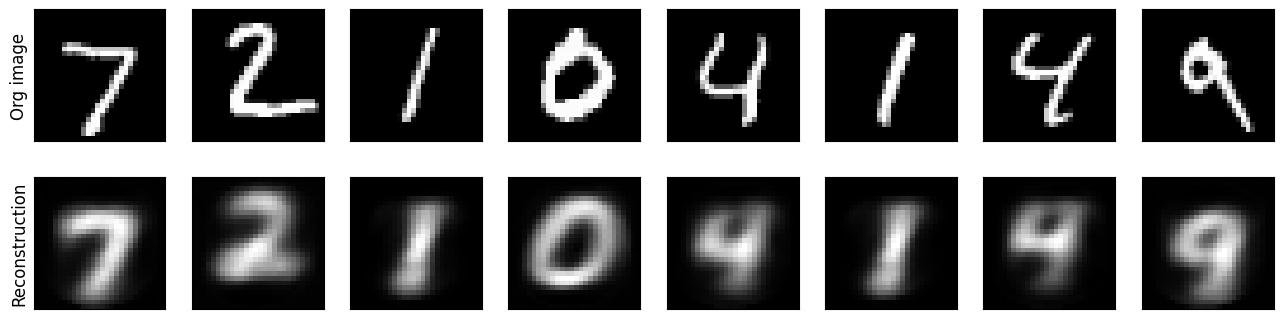

In [19]:
# Plot reconstructions
fig, axs = plt.subplots(2, 8, figsize=(16, 4))
axs[0, 0].set_ylabel('Org image', size='large')
axs[1, 0].set_ylabel('Reconstruction', size='large')
for i in range(8):
    axs[0, i].imshow(images[i], cmap='gray')
    axs[1, i].imshow(reconstructions[i], cmap='gray')
    axs[0, i].set_yticks([])
    axs[0, i].set_xticks([])
    axs[1, i].set_yticks([])
    axs[1, i].set_xticks([])

In [20]:
digit, label = dataset[0]
perturbed_reconstructions = []
perturbation_values = [0.05*i for i in range(-5, 6)]
digit_caps = get_digit_caps(model, digit)
for dimension in range(16):
    perturbed_reconstructions.append(
        dimension_perturbation_reconstructions(model, digit_caps, label,
                                               dimension, perturbation_values)
    )

/tmp/ipykernel_4182132/3938252321.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_ = Variable(image.unsqueeze(0), volatile=True)
/tmp/ipykernel_4182132/3938252321.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  target = Variable(torch.LongTensor([label]), volatile=True)


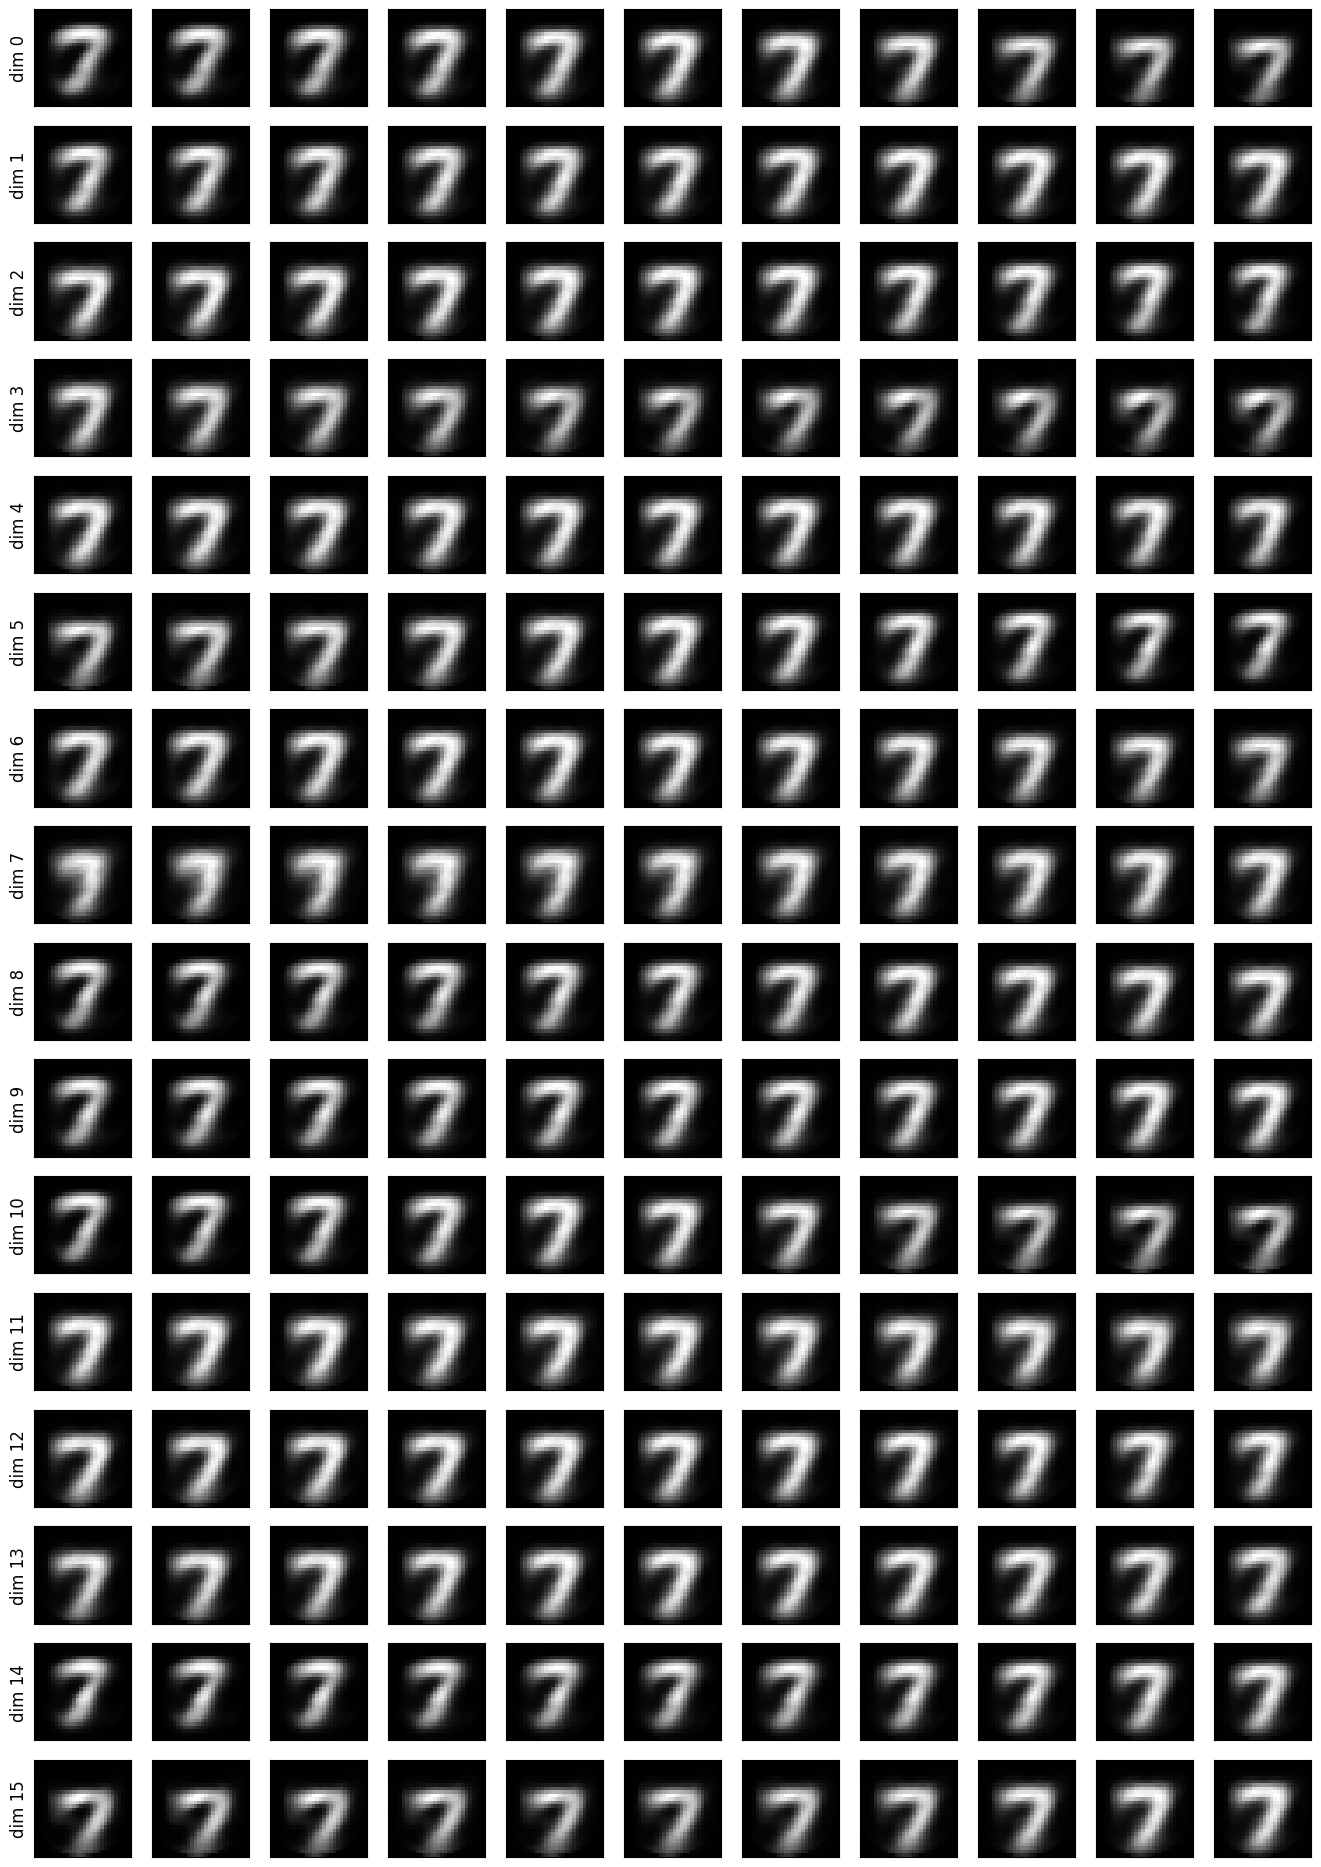

In [21]:
fig, axs = plt.subplots(16, 11, figsize=(11*1.5, 16*1.5))
for i in range(16):
    axs[i, 0].set_ylabel('dim {}'.format(i), size='large')
    for j in range(11):
        axs[i, j].imshow(perturbed_reconstructions[i][j], cmap='gray')
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])